In [1]:
import numpy as np
import functions as func
import matplotlib.pyplot as plt
import pdb, glob, mpld3
from astropy.io import fits, ascii
from astropy.wcs import WCS
from mpld3 import plugins

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)
mpld3.enable_notebook()

In [19]:
fnames = np.sort(np.concatenate((glob.glob('../bd601753/r37651968/ch1/bcd/*_bcd.fits'), 
                        glob.glob('../bd601753/r37851648/ch1/bcd/*_bcd.fits'), 
                        glob.glob('../bd601753/r37997056/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r38052352/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r38067712/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r38418944/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r38705664/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r38924800/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r39212544/ch1/bcd/*_bcd.fits'),
                        glob.glob('../bd601753/r39226880/ch1/bcd/*_bcd.fits'))))

In [41]:
hdu    = fits.open(fnames[4])
header = hdu[0].header
image  = hdu[0].data
hdu.info()
hdu.close()

Filename: ../bd601753/r37651968/ch1/bcd/SPITZER_I1_37651968_0004_0000_2_bcd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     323   (256, 256)   float32   


In [50]:
sky_crd = np.array([[261.2167, 60.4308]])

for i in range(100):
    hdu    = fits.open(fnames[i])
    header = hdu[0].header
    hdu.close()
    
    w = WCS(header)
    pix_crd = w.wcs_world2pix(sky_crd,1)
    print pix_crd

[[ 459.17370436  118.50290213]]
[[ 129.08881107  127.53869602]]
[[ 396.37381778  181.69567397]]
[[  66.71912569  190.58018645]]
[[ 522.07665814  181.56822206]]
[[ 192.01957388  190.36295653]]
[[ 521.70993979   55.74114005]]
[[ 191.86032814   64.77356611]]
[[ 396.02840084   56.20897813]]
[[ 66.35684791  65.04292416]]
[[ 459.73465561  117.72715146]]
[[ 130.05679022  126.77986096]]
[[ 396.95642748  180.8432506 ]]
[[  67.61349867  189.88153726]]
[[ 522.72639565  180.57522658]]
[[ 192.73443714  189.45509076]]
[[ 522.20153404   55.03726134]]
[[ 192.49328329   63.90911132]]
[[ 396.34394265   55.36542344]]
[[ 67.30504385  64.3899005 ]]
[[ 460.20710138  117.70339699]]
[[ 130.55829901  126.15691448]]
[[ 397.50044777  180.72834311]]
[[  67.96007907  189.13549004]]
[[ 522.97949806  180.20713028]]
[[ 193.51622931  188.91879026]]
[[ 522.62133162   54.6277518 ]]
[[ 193.197167     63.37609434]]
[[ 397.03722803   55.09138425]]
[[ 67.48810477  63.14102947]]
[[ 460.64674694  117.67552144]]
[[ 130.8525353

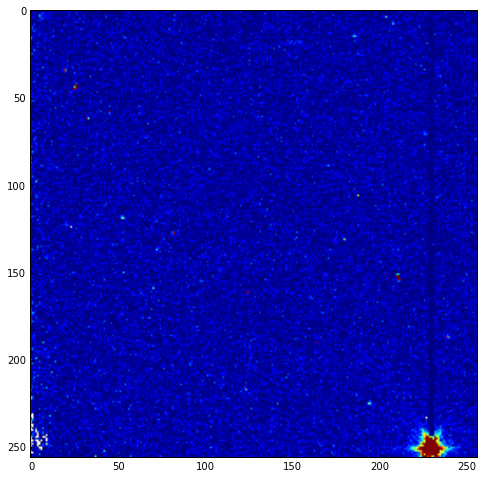

In [46]:
plt.imshow(image, vmin = 0, vmax = 10)